# Analyzing time-series data

## Content
1. Import libraries and data
2. Subsetting, wrangling, and cleaning time-series data
3. Time series analysis: decomposition
4. Testing for stationarity
5. Stationarizing
6. Forecarsting with ARIMA


## 1. Import libraries and data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# Set new limits for displaying rows
pd.set_option('display.max_rows', 1000)

In [3]:
# Option for created graphs to be displayed automatically
%matplotlib inline

In [4]:
# Turn project folder path into a string
path = r'C:\Users\Lara\Career Foundry Projects\Wake County Housing Market 2023'

# Import csv data file using os library
df = pd.read_csv (os.path.join(path, 'Data','Prepared Data', 'single_homes_new.csv'), index_col = False)

In [5]:
df.shape

(306560, 27)

In [6]:
df.head()

,real_estate_id,deeded_acreage,total_sale_price,assessed_building_value,assessed_land_value,year_built,units,heated_area,utilities,addition_year,...,house_age,effective_age,price_group,value_group,house_size,house_age_group,effective_age_group,sale_month,sale_year,sale_month_year
0,19,0.21,34500,134321,115000,1964,1,1828,ALL,0,...,59,43,Low price,Low value,Medium house,Old house,Effective mid-age house,1,1974,01/1974
1,20,0.46,35500,114933,45000,1970,1,1240,E,0,...,53,38,Low price,Low value,Small house,Old house,Effective mid-age house,5,1983,05/1983
2,22,0.46,37500,118723,32000,1900,1,2261,WSE,0,...,123,63,Low price,Low value,Medium house,Very old house,Effective old house,9,2004,09/2004
3,25,0.96,70000,358290,140000,1971,1,3770,WGE,0,...,52,52,Low price,Middle value,Big house,Old house,Effective old house,1,1971,01/1971
4,30,0.47,380000,161077,303875,1946,1,1789,ALL,2020,...,77,43,Middle price,Low value,Medium house,Old house,Effective mid-age house,8,2015,08/2015


## 2. Subsetting, wrangling, and cleaning time-series data

I'll drop column 'sale_month_year' to make a new one 'sale_year_month' in a format yyyy-mm. I'll use 2 columns 'sale_year' and 'sale_month' to do that. For time series I will use this newly created column as index column.

In [7]:
df = df.drop (columns = ['sale_month_year'])
df.shape

(306560, 26)

In [8]:
# Change data types of 2 columns to strings to join them later
df['sale_year'] = df['sale_year'].astype(str)
df['sale_month'] = df['sale_month'].astype(str)

In [9]:
# Create new column 'temp_clmn'
def f(row):
    if ((row['sale_month'] == '10') or (row['sale_month'] == '11') or (row['sale_month'] == '12')) : return '-'
    else : return '-0'

In [10]:
df['temp_clmn'] = df.apply(f, axis = 1)

In [11]:
# Create new column 'sale_year_month'
df['sale_year_month'] = df['sale_year'] + df['temp_clmn'] + df['sale_month']
df.shape

(306560, 28)

In [12]:
# Drop column 'temp_clmn'
df = df.drop (columns = ['temp_clmn'])

In [13]:
# Check the format
df['sale_year_month'].head()

0    1974-01
1    1983-05
2    2004-09
3    1971-01
4    2015-08
Name: sale_year_month, dtype: object

In [14]:
# Create subset of just 2 columns needed for time-series analysis
df_sub = df[['sale_year_month', 'total_sale_price']]

While exploring this dataset (single_houses_new.csv) in Excel I noticed that houses sold before 1980 had mostly January 1st as sale date for almost all years 1958-1979. I think 43 year would be a bit too long period to explore all data, so I will just look into houses sold in 21st century (2001-01 to 2023-10). 
Maybe I will need to remove some extreme values too to avoid multiple rounds of diferencing.

In [15]:
# Create subset of just sales made in 21st century
sub = df_sub.loc[df_sub['sale_year_month'] >= '2001-01']

In [16]:
sub.shape

(260029, 2)

I will group by each sale_year_month and aggregate by mean and median value of all total_sale_prices for houses sold in that particular month and year and then choose one from these 2 central tendency measures is better for further analysis.

In [17]:
# Group by each sale_year_month and aggregate by mean and median value of all total_sale_prices for houses sold in that
# particular month and year
sub.groupby('sale_year_month').agg({'total_sale_price':['mean', 'median']})

total_sale_price          
                            mean    median
sale_year_month                           
2001-01            210458.000000  167000.0
2001-02            197553.639847  167000.0
2001-03            209240.789474  175500.0
2001-04            214304.511278  170000.0
2001-05            208789.237668  174750.0
2001-06            214991.769547  175250.0
2001-07            202448.008850  171250.0
2001-08            211920.634921  176750.0
2001-09            204329.754601  175000.0
2001-10            210300.511509  173500.0
2001-11            209163.484487  175000.0
2001-12            201440.700809  167000.0
2002-01            223042.105263  179500.0
2002-02            215928.994083  174500.0
2002-03            208227.272727  179250.0
2002-04            217352.439024  173250.0
2002-05            207982.758621  170750.0
2002-06            223484.276730  184000.0
2002-07            218252.456332  178000.0
2002-08            220265.695067  184500.0
2002-09            214014.320388  176750.0
2002-10            216671.945701  173500.0
2002-11            218261.096606  176000.0
2002-12            212295.990566  168750.0
2003-01            207195.255474  175000.0
2003-02            198210.327456  169000.0
2003-03            218963.144963  179000.0
2003-04            215468.674699  178500.0
2003-05            211214.285714  177500.0
2003-06            226185.499058  188000.0
2003-07            230552.400000  197000.0
2003-08            225751.987281  196000.0
2003-09            214278.310940  181500.0
2003-10            237167.587477  195000.0
2003-11            223700.956938  189000.0
2003-12            225317.708333  198500.0
2004-01            236923.214286  200000.0
2004-02            222828.125000  189500.0
2004-03            225653.550864  186000.0
2004-04            220074.036511  181500.0
2004-05            230683.493590  187750.0
2004-06            252949.392713  210000.0
2004-07            242893.113343  200000.0
2004-08            241591.591592  194000.0
2004-09            231969.230769  191000.0
2004-10            232454.465849  188000.0
2004-11            235203.020134  199750.0
2004-12            247225.663717  206500.0
2005-01            243657.894737  199500.0
2005-02            252685.273159  212000.0
2005-03            235653.536977  190000.0
2005-04            242925.705795  197000.0
2005-05            240909.024745  205000.0
2005-06            257798.989298  226500.0
2005-07            245703.517588  213750.0
2005-08            264572.044335  221750.0
2005-09            242284.122563  200000.0
2005-10            262164.599092  223500.0
2005-11            248417.820069  212000.0
2005-12            261793.946188  215000.0
2006-01            256168.396794  206500.0
2006-02            266836.161616  224000.0
2006-03            267495.270270  217000.0
2006-04            255950.556818  219000.0
2006-05            255498.175182  214000.0
2006-06            286179.173511  240500.0
2006-07            264503.272959  223000.0
2006-08            266872.480181  215000.0
2006-09            266267.706920  218000.0
2006-10            278725.280899  235000.0
2006-11            284285.416283  226000.0
2006-12            263989.325843  221000.0
2007-01            255735.829960  210000.0
2007-02            282670.036765  228250.0
2007-03            272174.902471  228000.0
2007-04            273154.727794  220000.0
2007-05            275434.270712  226500.0
2007-06            290476.948408  236000.0
2007-07            289492.415403  240000.0
2007-08            281209.773540  232000.0
2007-09            270710.000000  223500.0
2007-10            286837.507123  244000.0
2007-11            270428.679818  225000.0
2007-12            265085.106383  226750.0
2008-01            267784.869976  214500.0
2008-02            279722.222222  225000.0
2008-03            282869.616105  241500.0
2008-04            269813.955250  225000.0
2008-05            289570.425665  245000.0
2008-06            301367.452229  261750.0
2008-07          

It is clear that higher sale prices for some houses (extreme values) makes mean value higher than median values by 30, 40 or even more thousands. I will use mean value, despite these differencies.

In [18]:
# Group by each month and calculate mean sale price and round it to whole numbers
mean_price = sub.groupby('sale_year_month')['total_sale_price'].mean().round(0)
mean_price

sale_year_month
2001-01    210458.0
2001-02    197554.0
2001-03    209241.0
2001-04    214305.0
2001-05    208789.0
2001-06    214992.0
2001-07    202448.0
2001-08    211921.0
2001-09    204330.0
2001-10    210301.0
2001-11    209163.0
2001-12    201441.0
2002-01    223042.0
2002-02    215929.0
2002-03    208227.0
2002-04    217352.0
2002-05    207983.0
2002-06    223484.0
2002-07    218252.0
2002-08    220266.0
2002-09    214014.0
2002-10    216672.0
2002-11    218261.0
2002-12    212296.0
2003-01    207195.0
2003-02    198210.0
2003-03    218963.0
2003-04    215469.0
2003-05    211214.0
2003-06    226185.0
2003-07    230552.0
2003-08    225752.0
2003-09    214278.0
2003-10    237168.0
2003-11    223701.0
2003-12    225318.0
2004-01    236923.0
2004-02    222828.0
2004-03    225654.0
2004-04    220074.0
2004-05    230683.0
2004-06    252949.0
2004-07    242893.0
2004-08    241592.0
2004-09    231969.0
2004-10    232454.0
2004-11    235203.0
2004-12    247226.0
2005-01    243658.0
2005

In [19]:
# Make new data frame
df_new = pd.DataFrame({'date': mean_price.index, 'mean_price': mean_price.values})
df_new

,date,mean_price
0,2001-01,210458.0
1,2001-02,197554.0
2,2001-03,209241.0
3,2001-04,214305.0
4,2001-05,208789.0
5,2001-06,214992.0
6,2001-07,202448.0
7,2001-08,211921.0
8,2001-09,204330.0
9,2001-10,210301.0


In [20]:
# Change data type to integer
df_new['mean_price'] = df_new['mean_price'].astype(int)
df_new.head()

,date,mean_price
0,2001-01,210458
1,2001-02,197554
2,2001-03,209241
3,2001-04,214305
4,2001-05,208789


In [21]:
# Set the "date" column as the index

from datetime import datetime

df_new['datetime'] = pd.to_datetime(df_new['date']) # Create a datetime column from 'date'
df_new = df_new.set_index('datetime') # Set the datetime as the index of the dataframe
df_new.drop(['date'], axis = 1, inplace = True) # Drop the "date" column
df_new.head()

,mean_price
datetime,
2001-01-01,210458
2001-02-01,197554
2001-03-01,209241
2001-04-01,214305
2001-05-01,208789


#### Comment:
In original dataset majority of houses have full date (with days, months and years), but i separated this column into 3 and then made new one with just months and years. For time-series I would need uniform distance between each interval and that would not be possible to achieve with houses which were not sold on each day of the year. Here I am analyzing just average prices per each month and it is totally fine that the date is set to a first day of each month like it is shown above.

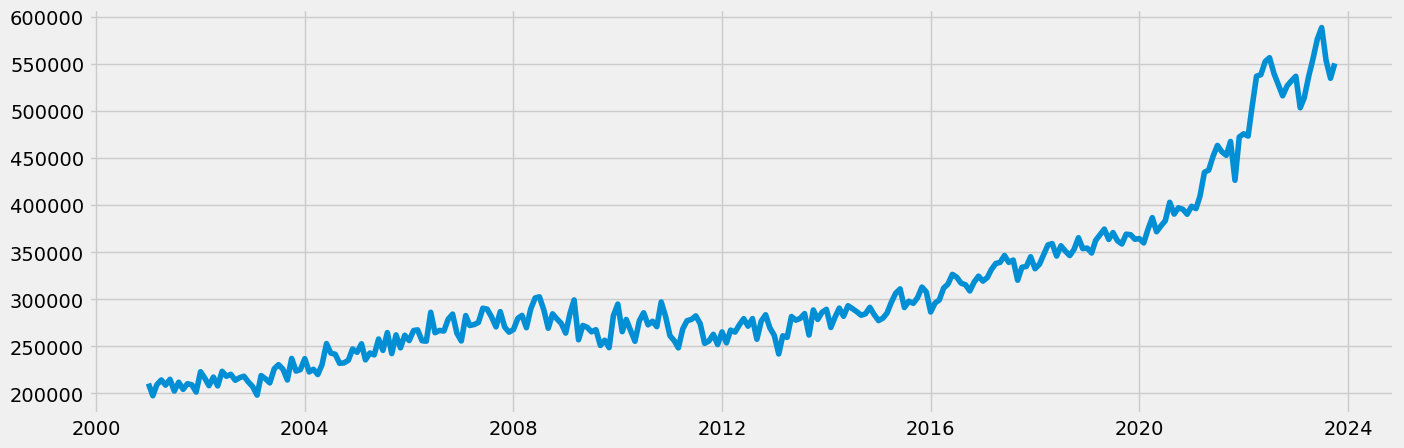

In [22]:
# Plot the dataset

plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_new)

It looks like there is a general upward trend.

In [24]:
# Check if there are missing values
df_new.isnull().sum() 

mean_price    0
dtype: int64

In [26]:
# Check for duplicates
dups = df_new.duplicated()
dups.sum()

0

No missing values found and no duplicates.

## 3.Time-series analysis: decomposition

In [27]:
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(df_new, model='additive')

In [28]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

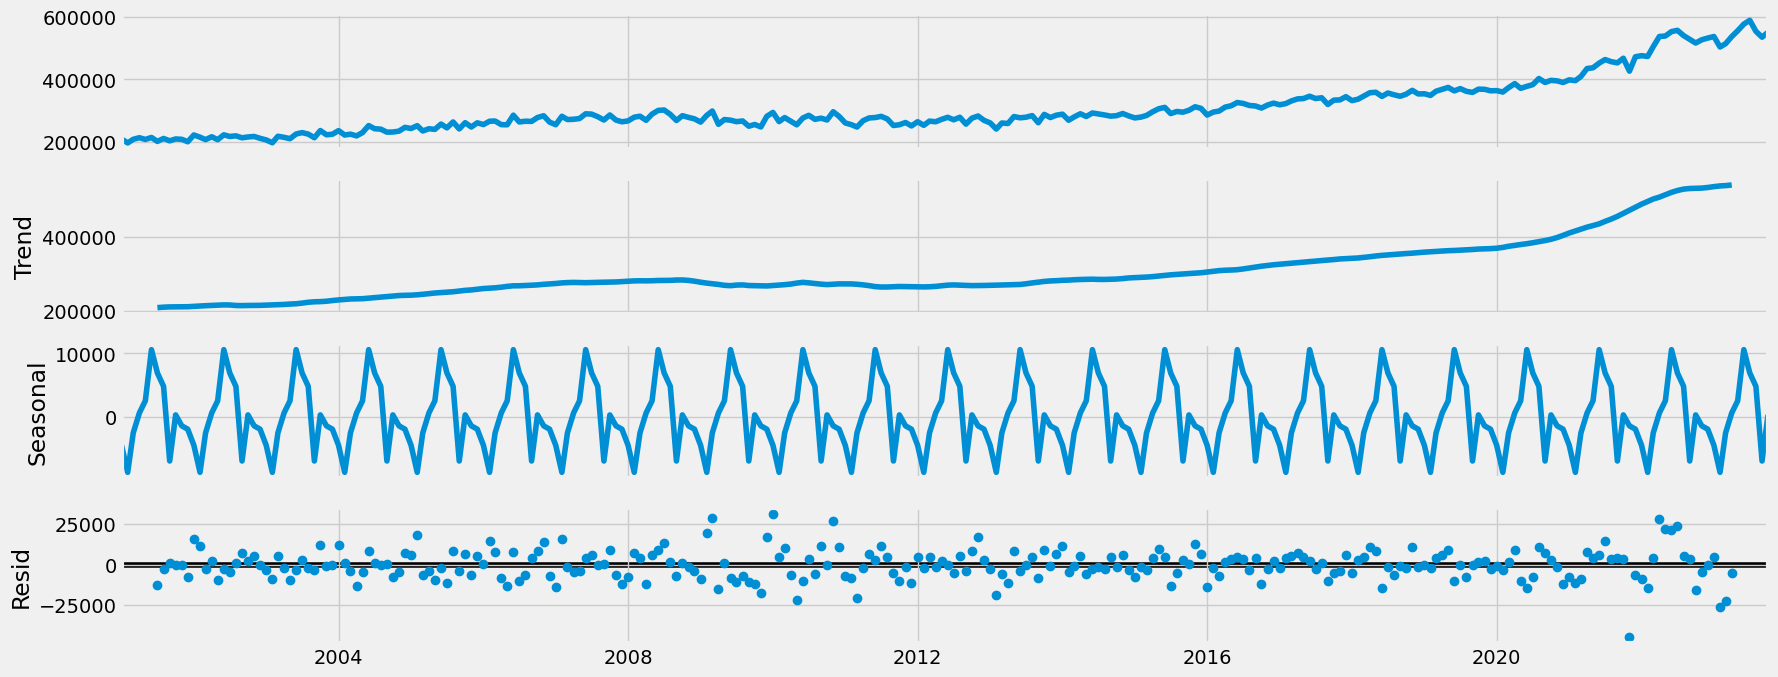

In [29]:
# Plot the separate components

decomposition.plot()
plt.show()

Trend is an upward trend and there is also a seasonality presetn with a lot of noise. Level needs smoothing.

### 4. Testing for stationarity

In [31]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries):
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_new['mean_price'])

Dickey-Fuller Stationarity test:
Test Statistic                   2.003297
p-value                          0.998677
Number of Lags Used             13.000000
Number of Observations Used    260.000000
Critical Value (1%)             -3.455754
Critical Value (5%)             -2.872721
Critical Value (10%)            -2.572728
dtype: float64


Test statstic is a a lot bigger than critical values and p-value is close to 1. I will need to difference data.

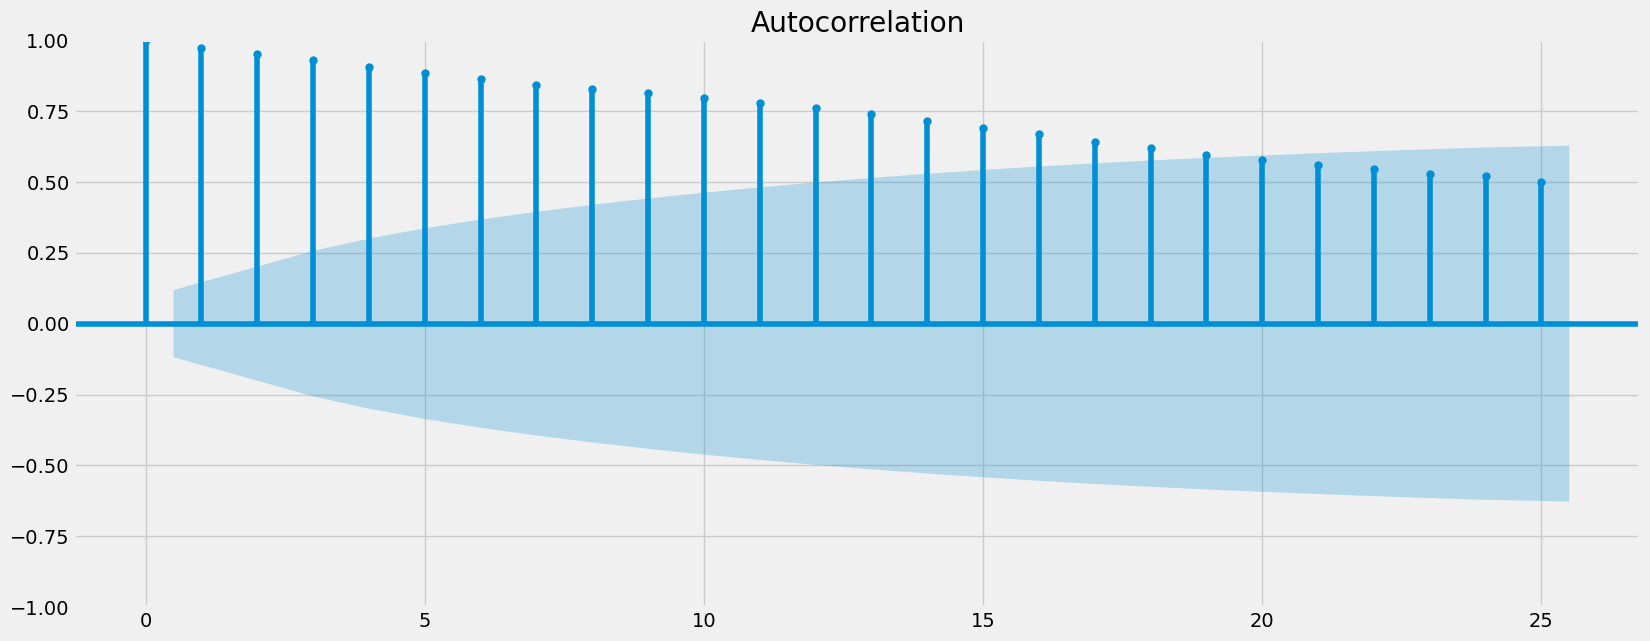

In [33]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Import the autocorrelation and partial correlation plots

plot_acf(df_new)
plt.show()

This plot also shows that i need to smooth out data.

## 5. Stationarizing

In [35]:
# Differencing t - (t - 1)
df_diff = df_new - df_new.shift(1)

In [36]:
# Remove missing values made by differencing
df_diff.dropna(inplace = True)

In [37]:
df_diff.head()

,mean_price
datetime,
2001-02-01,-12904.0
2001-03-01,11687.0
2001-04-01,5064.0
2001-05-01,-5516.0
2001-06-01,6203.0


In [38]:
df_diff.columns

Index(['mean_price'], dtype='object')

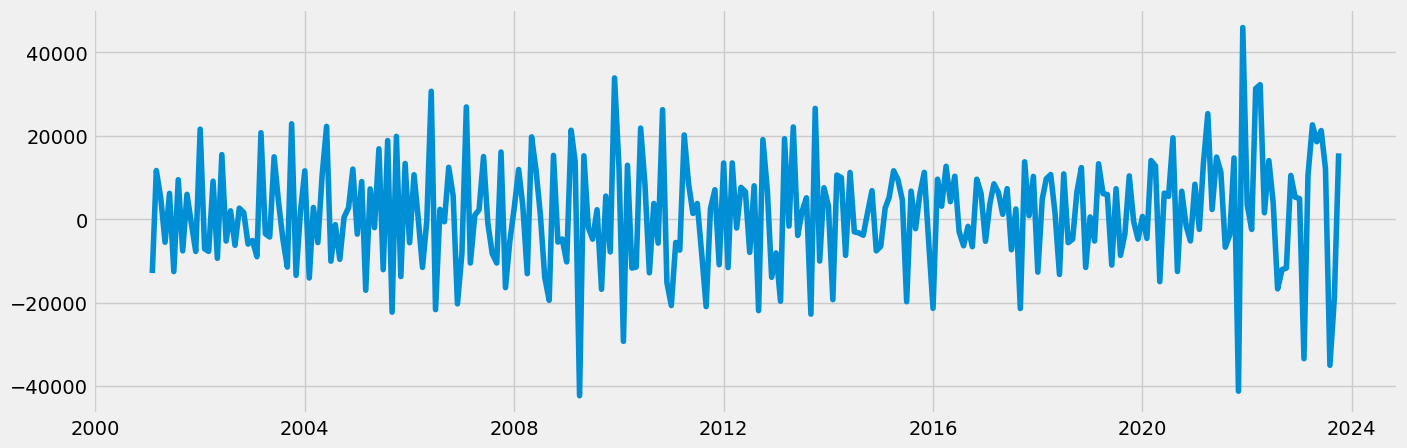

In [39]:
# Check out what the differencing did to the time-series curve
plt.figure(figsize = (15,5), dpi = 100)
plt.plot(df_diff)

In [40]:
dickey_fuller(df_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -2.698642
p-value                          0.074274
Number of Lags Used             15.000000
Number of Observations Used    257.000000
Critical Value (1%)             -3.456054
Critical Value (5%)             -2.872853
Critical Value (10%)            -2.572799
dtype: float64


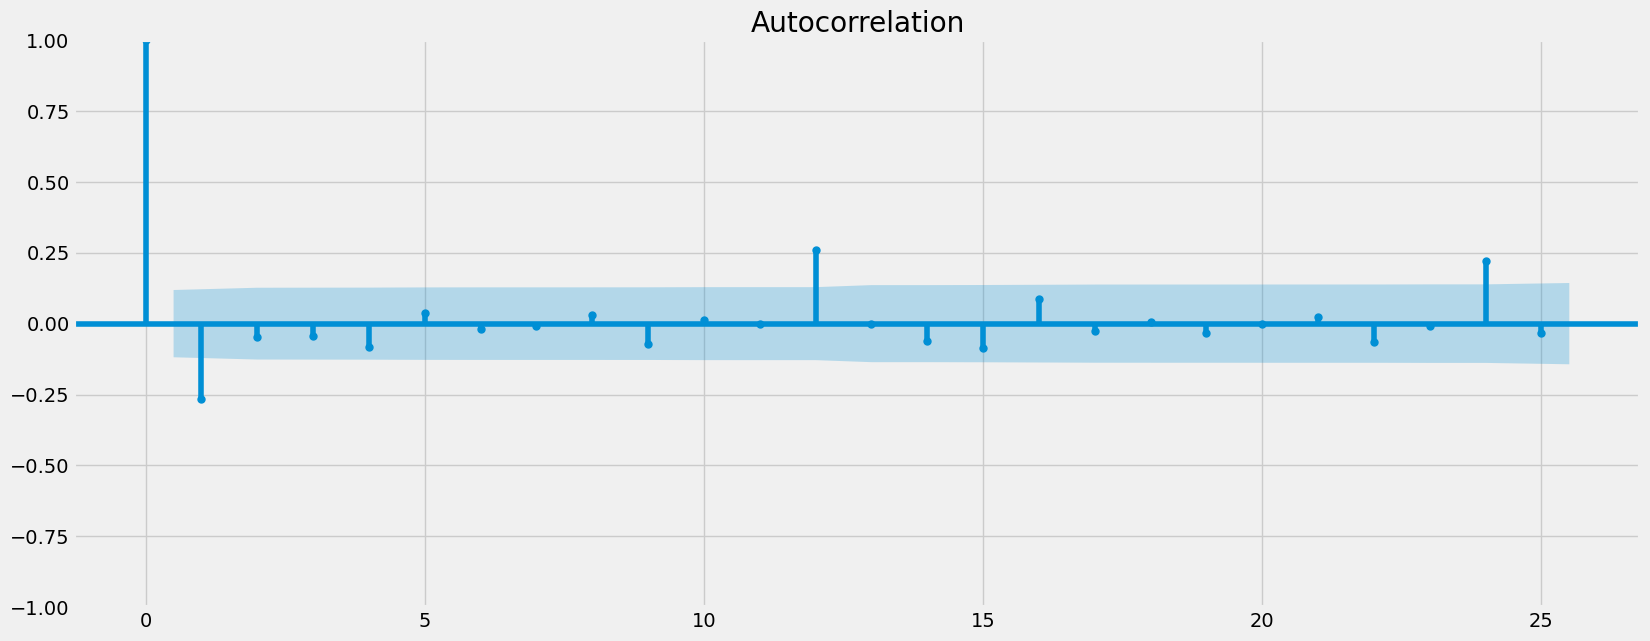

In [41]:
plot_acf(df_diff)
plt.show()

Null Hypothesis: "Series has a unit root." (Meaning it is non-stationary.)

Alternative Hypothesis: "Series doesn't have a unit root." (Meaning it is stationary.)

#### Conclusion:
Test statistic is smaller than 10% Critical value, but p-value is 0.07 and it is still larger than 0.05. That doesn't matter because level of significance is alpha = 0.1 here, because we are looking at 10% Critical value. And if p-value is smaller than level of significance, than we are rejecting the Null Hypothesis. Which means that now we have a stationary series. But a weak one.

Autocorrelation plot shows only 3 lines outside of blue confidence level, which is acceptabale.

## 6. Forecarsting with ARIMA

#### Parameters

1. p is the number of autoregressive terms (AR)
2. d is the number of nonseasonal differences (I)
3. q is the number of lagged forecast errors in the prediction equation (MA)

Parameter d (differencing) is d = 1 because series was differenced only once.

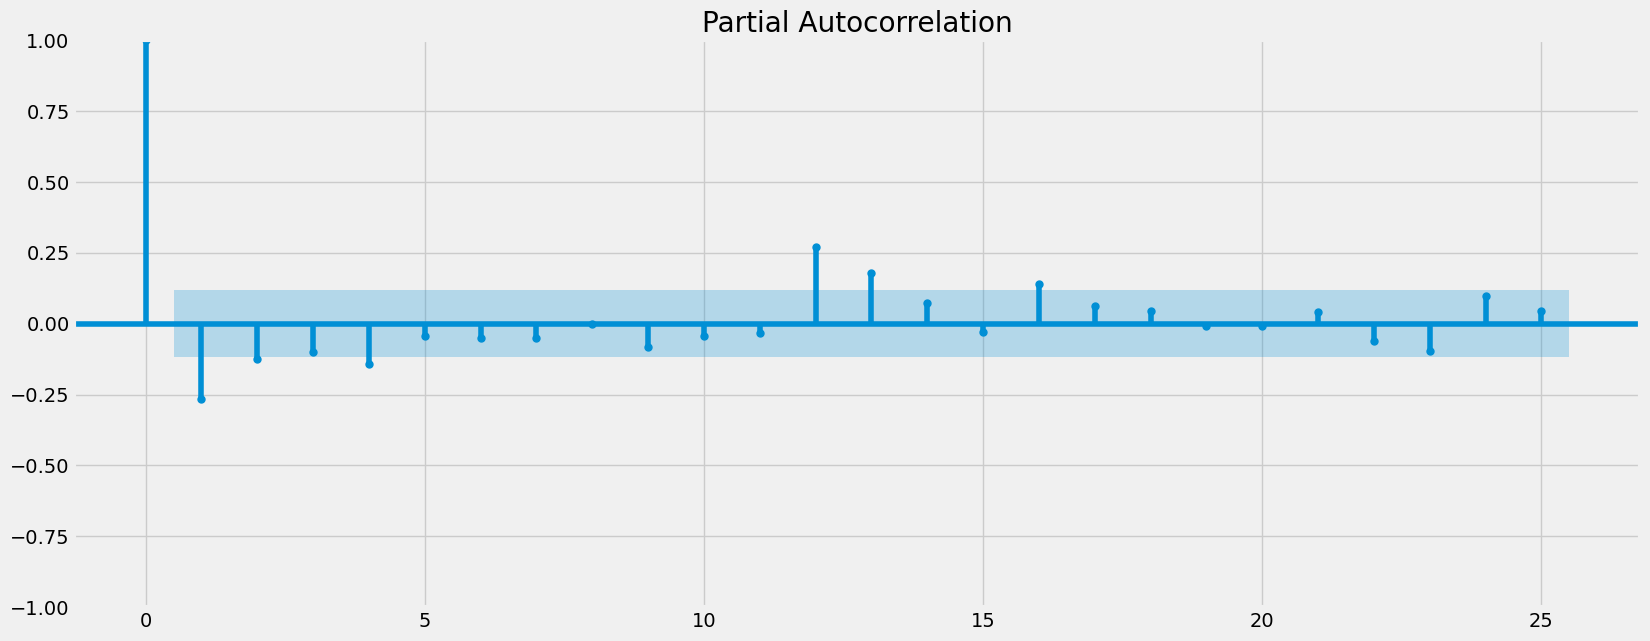

In [51]:
# Plot partial autocorrelations to determine parameter p
plot_pacf(df_diff)
plt.show()

Here we see that the first lag is significanty out of the limit, and second one is in a negative already. We can choose p parameter to be p = 1, because it represents number of lags that are not required in the autoregression part.

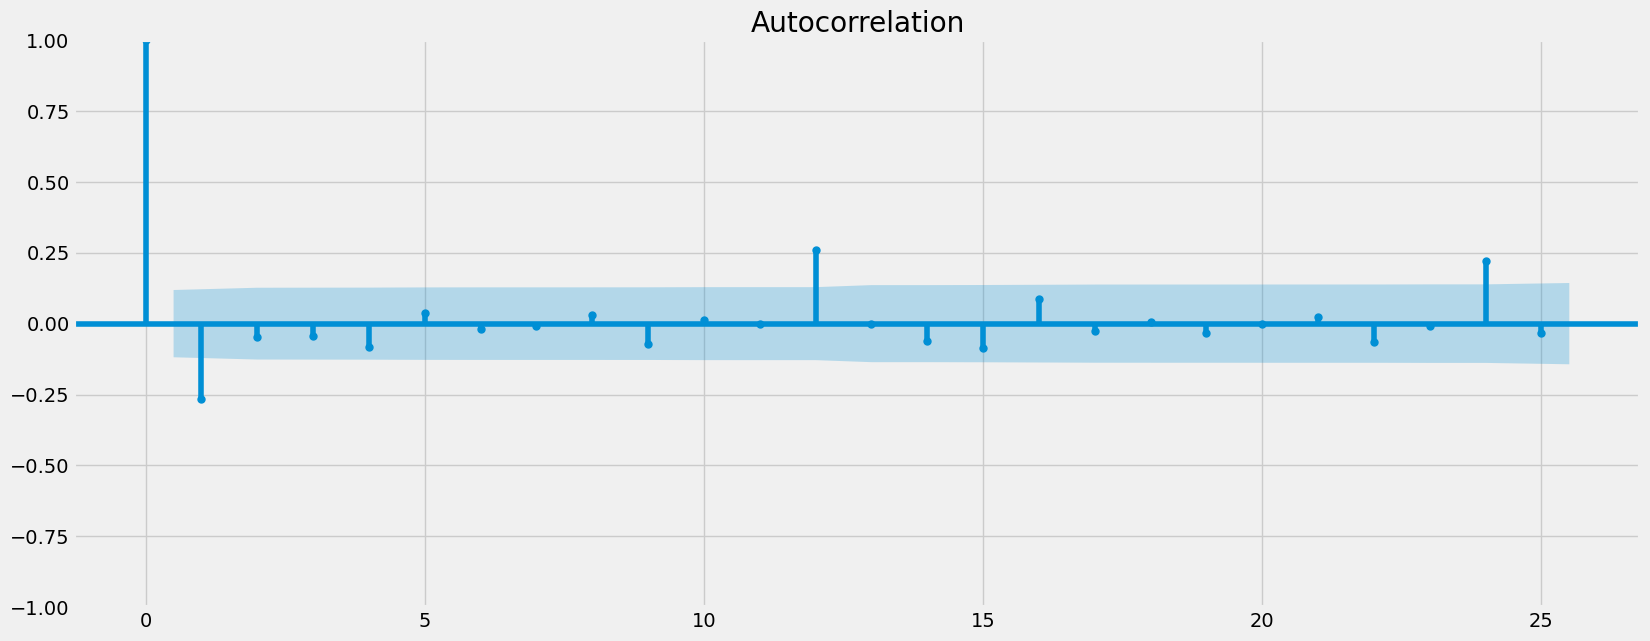

In [52]:
# Plot autocorrelations again to determine parameter q
plot_acf(df_diff)
plt.show()

There are 4 lags out of limits (out of blue area), but only one significantly. I will set q parameter to be q = 1 and seee what results look like and built up towards q = 4 if needed.

All together we now have ARIMA(1, 1, 1)

### Splitting the Data

In [56]:
df_diff.shape

(273, 1)

In [67]:
# Split the data 
# Test is set to the March of 2020 just when COVID-19 lockdown happened across the US
# 273 - 10 - 12 - 12 - 9 = 230 going backwards from October 2023 to March 2020
train = df_diff['mean_price'][:231]
test = df_diff['mean_price'][230:]

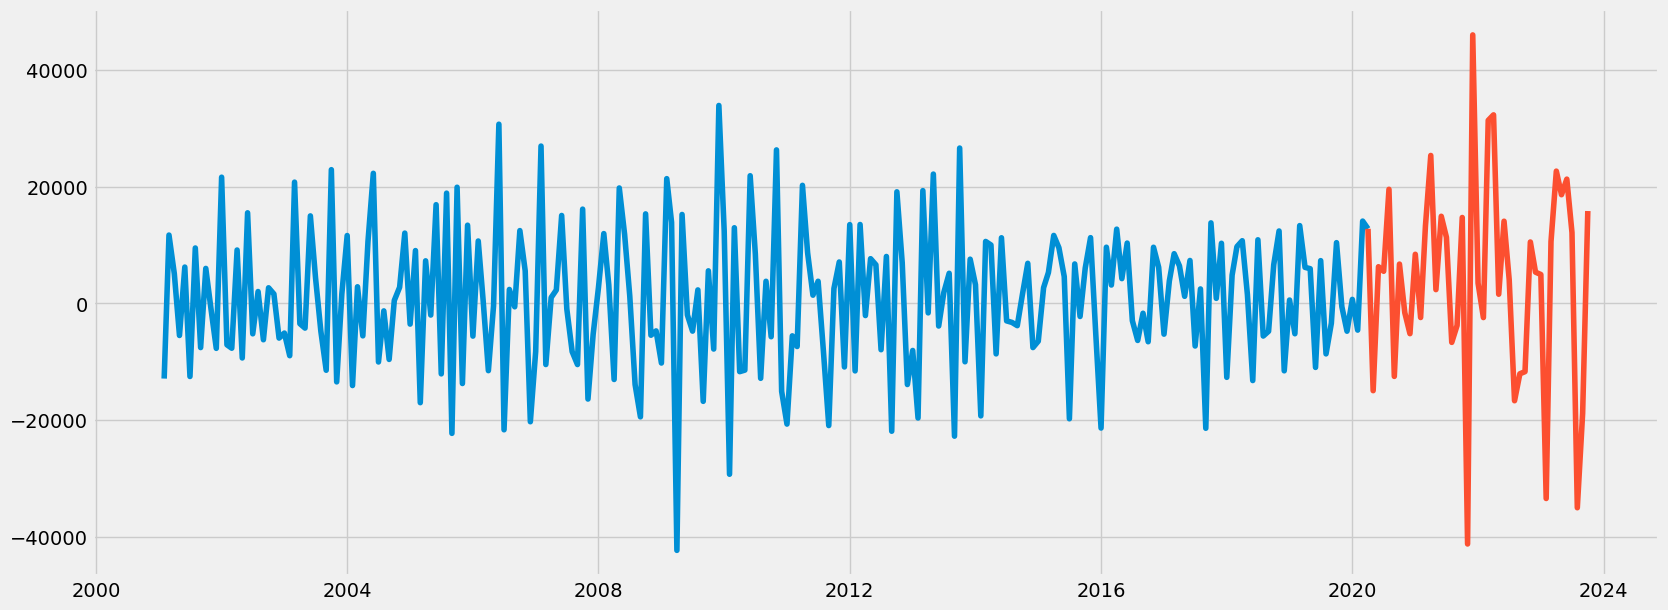

In [68]:
# Plot both sets in order to see the split
plt.plot(train)
plt.plot(test)

In [69]:
test.shape

(43,)

### Running and Fitting the Model

In [71]:
# Import ARIMA model
from statsmodels.tsa.api import ARIMA

In [76]:
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit()  
print(fitted.summary()) # Check model summary

# Forecast
# Size of test set is 43 and alpha is 0.05 ( that is 95% confidence interval)
fc, se, conf = fitted.forecast(43, alpha = 0.05)

# Make into pandas series
fc_series = pd.Series(fc, index=test.index) # This creates the forecasted curve
lower_series = pd.Series(conf[:, 0], index=test.index) # lower bound of the confidence interval
upper_series = pd.Series(conf[:, 1], index=test.index) # Upper bound of the confidence interval

# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05) # This creates the confidence interval
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                               SARIMAX Results                                
Dep. Variable:             mean_price   No. Observations:                  231
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2473.298
Date:                Fri, 10 Nov 2023   AIC                           4952.596
Time:                        03:52:17   BIC                           4962.910
Sample:                    02-01-2001   HQIC                          4956.756
                         - 04-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3501      0.062     -5.642      0.000      -0.472      -0.228
ma.L1         -1.0000      0.090    -11.166      0.000      -1.176      -0.824
sigma2      1.254e+08   7.14e-10   1.76e+17      0.0

ValueError: too many values to unpack (expected 3)

### Iterating

In [77]:
model = ARIMA(train, order=(4, 1, 1))  
fitted = model.fit()  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(41, alpha=0.05)  # 95% conf

# Make into pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                               SARIMAX Results                                
Dep. Variable:             mean_price   No. Observations:                  231
Model:                 ARIMA(4, 1, 1)   Log Likelihood               -2464.926
Date:                Fri, 10 Nov 2023   AIC                           4941.851
Time:                        03:55:21   BIC                           4962.480
Sample:                    02-01-2001   HQIC                          4950.172
                         - 04-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5123      0.091     -5.642      0.000      -0.690      -0.334
ar.L2         -0.3497      0.100     -3.505      0.000      -0.545      -0.154
ar.L3         -0.3179      0.104     -3.060      0.0

ValueError: too many values to unpack (expected 3)

In [78]:
model = ARIMA(train, order=(4, 1, 2))  
fitted = model.fit()  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(41, alpha=0.05)  # 95% conf

# Make into pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                               SARIMAX Results                                
Dep. Variable:             mean_price   No. Observations:                  231
Model:                 ARIMA(4, 1, 2)   Log Likelihood               -2457.129
Date:                Fri, 10 Nov 2023   AIC                           4928.259
Time:                        03:55:46   BIC                           4952.325
Sample:                    02-01-2001   HQIC                          4937.967
                         - 04-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3189      0.112      2.854      0.004       0.100       0.538
ar.L2          0.0396      0.106      0.373      0.709      -0.169       0.248
ar.L3         -0.0674      0.100     -0.676      0.4

ValueError: too many values to unpack (expected 3)